In [120]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

test_img = np.load('k49-test-imgs.npz')
test_labels = np.load('k49-test-labels.npz')
train_img = np.load('k49-train-imgs.npz')
train_labels = np.load('k49-train-labels.npz')

https://github.com/rois-codh/kmnist

These are the mappings between the labels and actaul kanji

0,U+3042,あ

1,U+3044,い

2,U+3046,う

3,U+3048,え

4,U+304A,お

5,U+304B,か

6,U+304D,き

7,U+304F,く

8,U+3051,け

9,U+3053,こ

10,U+3055,さ

11,U+3057,し

12,U+3059,す

13,U+305B,せ

14,U+305D,そ

15,U+305F,た

16,U+3061,ち

17,U+3064,つ

18,U+3066,て

19,U+3068,と

20,U+306A,な

21,U+306B,に

22,U+306C,ぬ

23,U+306D,ね

24,U+306E,の

25,U+306F,は

26,U+3072,ひ

27,U+3075,ふ

28,U+3078,へ

29,U+307B,ほ

30,U+307E,ま

31,U+307F,み

32,U+3080,む

33,U+3081,め

34,U+3082,も

35,U+3084,や

36,U+3086,ゆ

37,U+3088,よ

38,U+3089,ら

39,U+308A,り

40,U+308B,る

41,U+308C,れ

42,U+308D,ろ

43,U+308F,わ

44,U+3090,ゐ

45,U+3091,ゑ

46,U+3092,を

47,U+3093,ん

48,U+309D,ゝ

In [159]:
print(np.isnan(test_img).any())
print(np.isnan(test_labels).any())
print(np.isnan(train_img).any())
print(np.isnan(train_labels).any())

False
False
False
False


In [121]:
test_img = test_img['arr_0'] 
test_flattened_images = test_img.reshape(test_img.shape[0], -1)
test_labels = test_labels['arr_0'] 
test_flattened_label = test_labels.reshape(test_labels.shape[0], -1)
train_img = train_img['arr_0'] 
train_flattened_images = train_img.reshape(train_img.shape[0], -1)
train_labels = train_labels['arr_0'] 
train_flattened_label = train_labels.reshape(train_labels.shape[0], -1)

train_df = pd.DataFrame(train_flattened_images[:12000])
train_labels_df = pd.DataFrame(train_flattened_label[:12000], columns=['label'])
test_df = pd.DataFrame(test_flattened_images[:2400])
test_labels_df = pd.DataFrame(test_flattened_label[:2400], columns=['label'])

In [122]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)

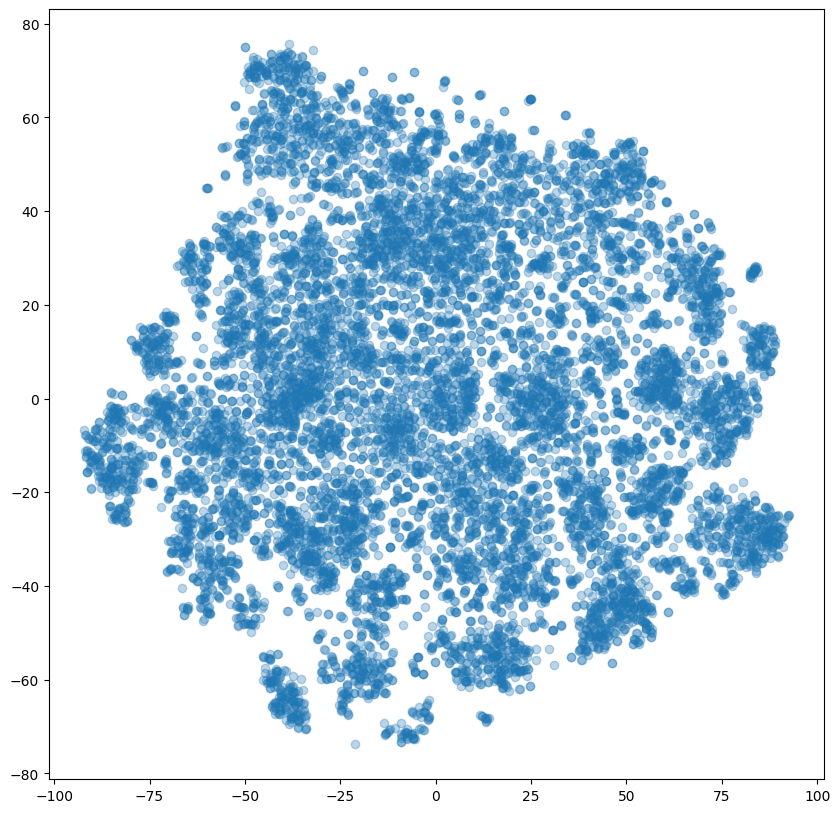

In [123]:
from sklearn.manifold import TSNE
%matplotlib inline

tsne = TSNE(n_components=2, random_state=0)
X_subset_2D = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 10))
plt.scatter(X_subset_2D[:, 0], X_subset_2D[:, 1], alpha=0.3)
plt.show()

### EDA

Since we are eventually going to use a neural network model, we need to min-max scale the data. As values in the range [0,1] work well for activation functions and can improve convergence.

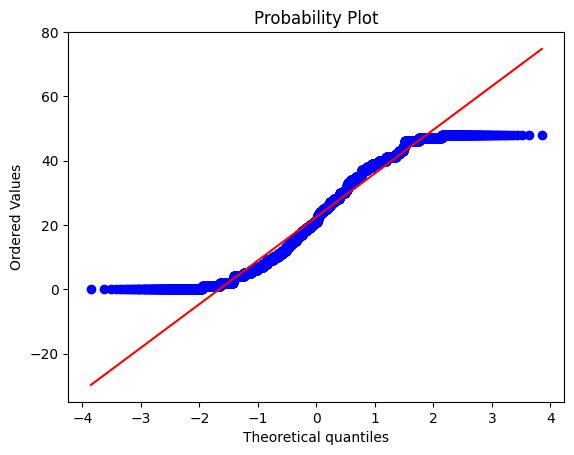

In [124]:
stats.probplot(train_labels_df['label'], dist="norm", plot=plt)
plt.show()

/home/mroohwee/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mroohwee/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mroohwee/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


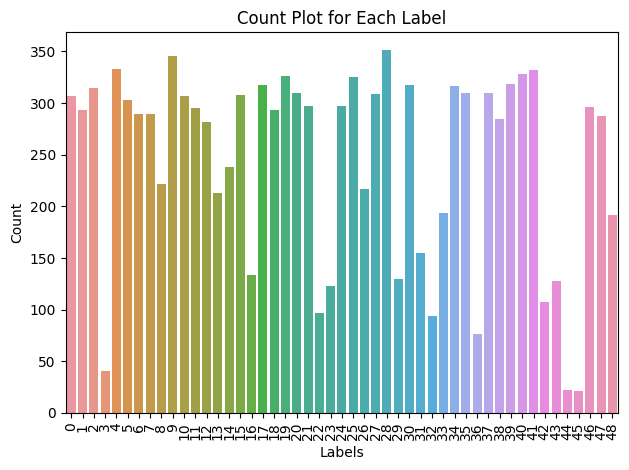

In [125]:
sns.countplot(x='label', data=train_labels_df)

plt.title('Count Plot for Each Label')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

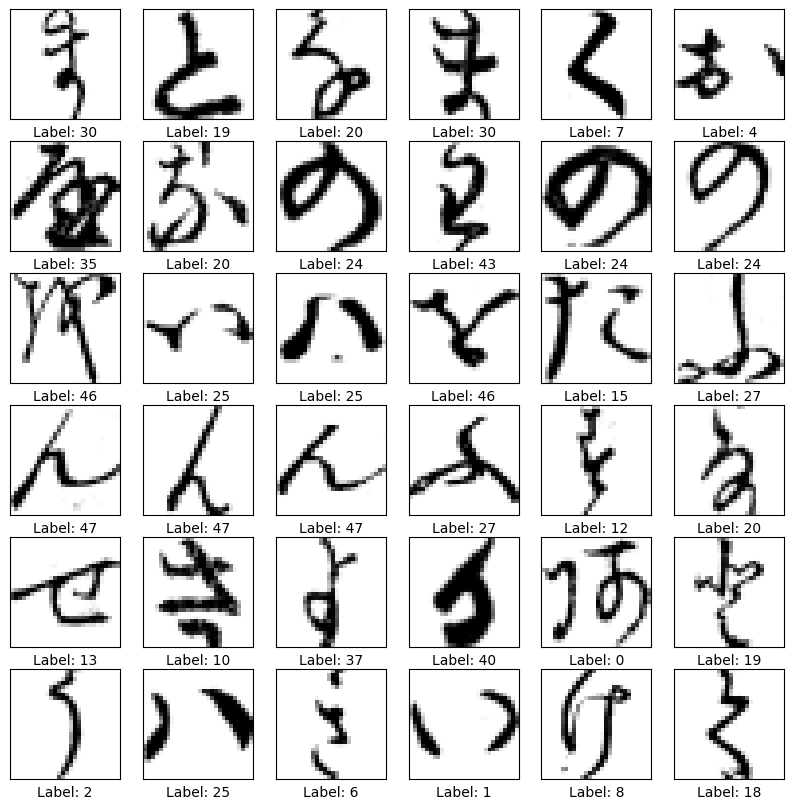

In [126]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    temp = train_labels_df.loc[i, 'label']
    plt.xlabel(f'Label: {temp}')
plt.show()

### Support Vector Classification (SVC)

Using Linear SVC as normal SVC does not perform well with datasets with more than 10,000 samples.

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

y_train = train_labels_df.squeeze()
y_test = test_labels_df.squeeze()

svc_model = LinearSVC(dual=False)
svc_model.fit(X_train, y_train)

svc_predict_train = svc_model.predict(X_train)
svc_predict = svc_model.predict(X_test)

svc_score_train = f1_score(y_train, svc_predict_train, average='weighted')
svc_score = f1_score(y_test, svc_predict, average='weighted')

print(f'Train SVC F1 Score: {svc_score_train:.3f}')
print(f'Test SVC F1 Score: {svc_score:.3f}')

Train SVC F1 Score: 0.942
Test SVC F1 Score: 0.424


In [129]:
from sklearn.metrics import classification_report

param_grid = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],  
    'max_iter': [1000, 5000] 
}

svc = LinearSVC(random_state=42, dual=False)

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_svc = LinearSVC(C=best_params['C'],
                     loss=best_params['loss'],
                     max_iter=best_params['max_iter'],
                     random_state=42,
                     dual=False)

best_svc.fit(X_train, y_train)

best_svc_pred = best_svc.predict(X_test)

accuracy = grid_search.best_score_
best_svc_train = best_svc.score(X_train, y_train)
best_svc_test = best_svc.score(X_test, y_test)

print(f"Best cross-validation F1 Score: {accuracy:.3f}")
print(f"Train set F1 Score: {best_svc_train:.3f}")
print(f"Test set F1 Score: {best_svc_test:.3f}")
print(classification_report(y_test, best_svc_pred))

/home/mroohwee/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mroohwee/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mroohwee/.local/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/mroohwee/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 315, in fit
    self.coef_, self.intercept_, n_iter_ = 

Best parameters: {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000}
Best cross-validation F1 Score: 0.585
Train set F1 Score: 0.876
Test set F1 Score: 0.482
              precision    recall  f1-score   support

           0       0.49      0.49      0.49        67
           1       0.78      0.72      0.75        64
           2       0.67      0.86      0.75        78
           3       0.00      0.00      0.00         5
           4       0.56      0.52      0.54        58
           5       0.37      0.25      0.29        77
           6       0.44      0.37      0.40        70
           7       0.50      0.49      0.50        69
           8       0.31      0.28      0.30        46
           9       0.51      0.51      0.51        57
          10       0.67      0.51      0.58        78
          11       0.51      0.75      0.61        57
          12       0.31      0.30      0.31        60
          13       0.59      0.50      0.54        44
          14       0.42      

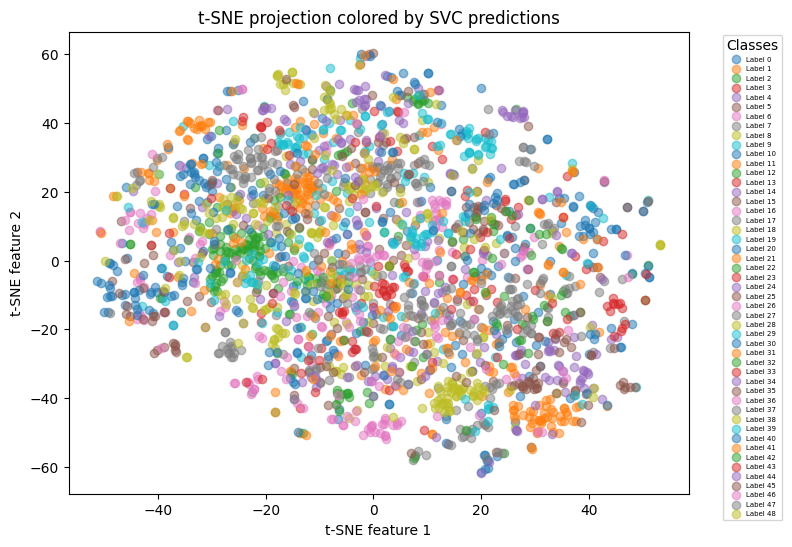

In [130]:
unique_labels = np.unique(best_svc_pred)
tsne = TSNE(n_components=2, random_state=0)
X_subset_2D = tsne.fit_transform(X_test)

plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(X_subset_2D[best_svc_pred == label, 0], 
                X_subset_2D[best_svc_pred == label, 1], 
                label=f'Label {label}',
                alpha=0.5)

plt.legend(handlelength=2, fontsize=5, handletextpad=0.5, borderpad=0.5, bbox_to_anchor=(1.05, 1),title="Classes")
plt.title('t-SNE projection colored by SVC predictions')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

### K-nearest Neighbors

In [131]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=49)
knn.fit(X_train, y_train)

knn_predict = knn.predict(X_test)
knn_predict_train = knn.predict(X_train)

knn_score_train = f1_score(y_train, knn_predict_train, average='weighted')
print(f'Train KNN F1 Score: {knn_score_train:.3f}')
knn_score = f1_score(y_test, knn_predict, average='weighted')
print(f'Test KNN F1 Score: {knn_score:.3f}')

Train KNN F1 Score: 0.667
Test KNN F1 Score: 0.503


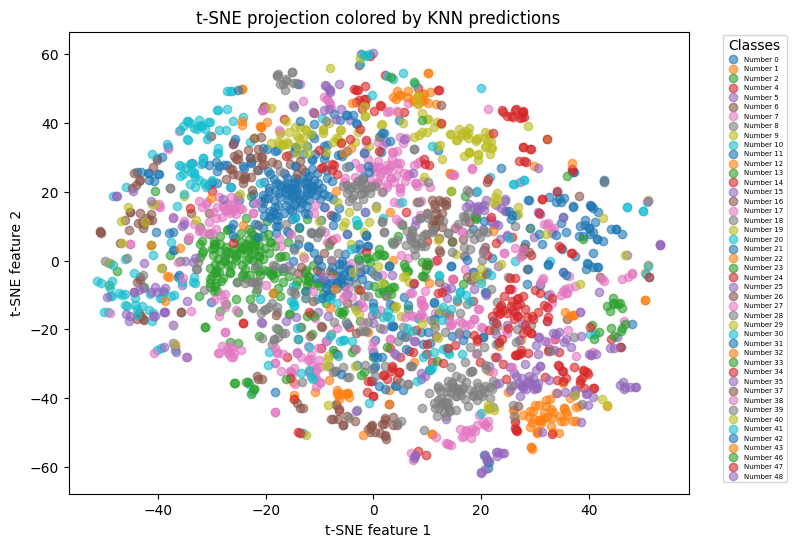

In [132]:
unique_labels = np.unique(knn_predict)
tsne = TSNE(n_components=2, random_state=0)
X_subset_2D = tsne.fit_transform(X_test)

plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(X_subset_2D[knn_predict == label, 0], 
                X_subset_2D[knn_predict == label, 1], 
                label=f'Number {label}',
                alpha=0.6)

plt.legend(handlelength=2, fontsize=5, handletextpad=0.5, borderpad=0.5, bbox_to_anchor=(1.05, 1),title="Classes")
plt.title('t-SNE projection colored by KNN predictions')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [133]:
param_grid = {
    'n_neighbors': [49],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [49],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='f1_weighted')

In [134]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 49, 'weights': 'distance'}
Best cross-validation F1 score: 0.6336032678644706


In [135]:
best_params = grid_search.best_params_

best_knn = KNeighborsClassifier(n_neighbors=49,
                                weights=best_params['weights'],
                                metric=best_params['metric'])

best_knn.fit(X_train, y_train)

best_knn_pred = best_knn.predict(X_test)
best_knn_train = best_knn.predict(X_train)
best_knn_f1 = f1_score(y_test, best_knn_pred, average='weighted')
best_knn_f1_train = f1_score(y_train, best_knn_train, average='weighted')

print(f"F1 Score of the KNN classifier with the best parameters on train set: {best_knn_f1_train}")
print(f"F1 Score of the KNN classifier with the best parameters on test set: {best_knn_f1:.2f}")

F1 Score of the KNN classifier with the best parameters on train set: 1.0
F1 Score of the KNN classifier with the best parameters on test set: 0.51


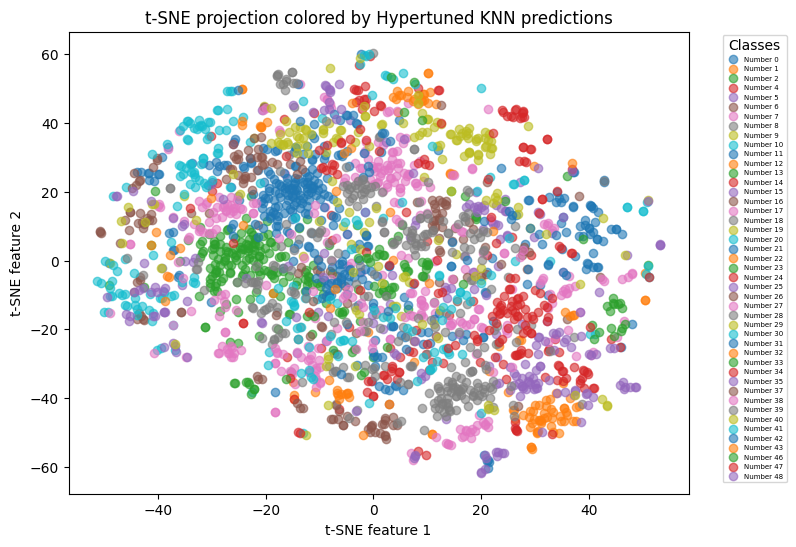

In [136]:
tsne = TSNE(n_components=2, random_state=0)
X_subset_2D = tsne.fit_transform(X_test)

plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(X_subset_2D[best_knn_pred == label, 0], 
                X_subset_2D[best_knn_pred == label, 1], 
                label=f'Number {label}',
                alpha=0.6)

plt.legend(handlelength=2, fontsize=5, handletextpad=0.5, borderpad=0.5, bbox_to_anchor=(1.05, 1),title="Classes")
plt.title('t-SNE projection colored by Hypertuned KNN predictions')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

### Convolutional Neural Network (CNN)

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Loading entire dataset, as the NN can pick up on more complex patterns
train_df = pd.DataFrame(train_flattened_images)
train_labels_df = pd.DataFrame(train_flattened_label, columns=['label'])
test_df = pd.DataFrame(test_flattened_images)
test_labels_df = pd.DataFrame(test_flattened_label, columns=['label'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)

pixels_x_train = X_train.reshape((-1, 1, 28, 28)) # Reshape for 1 channel, 28x28 pixels
X_train = torch.tensor(pixels_x_train, dtype=torch.float32)
pixels_x_test = X_test.reshape((-1, 1, 28, 28)) 
X_test = torch.tensor(pixels_x_test, dtype=torch.float32)

y_train = torch.tensor(train_labels_df.values, dtype=torch.int64).squeeze()
y_test = torch.tensor(test_labels_df.values, dtype=torch.int64).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [138]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

Using batch training for the CNN.

In [139]:
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [140]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 49)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 7 * 7)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [141]:

def train(model, device, train_loader, optimizer, epoch, loss_function):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    return train_loss

def test(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100 * correct / len(test_loader.dataset)))
    return test_loss

def evaluate(model, device, data_loader):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect all the targets and predictions
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_targets, all_predictions, average='weighted')
    return f1

In [142]:
nn_model = CNN().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

train_losses = []
test_losses = []
num_epochs = 6

for epoch in range(1, num_epochs + 1):
    train_loss = train(nn_model, device, train_loader, optimizer, epoch, loss_function)
    train_losses.append(train_loss)
    test_loss = test(nn_model, device, test_loader, loss_function)
    test_losses.append(test_loss)

Train Epoch: 1 [0/232365 (0%)]	Loss: 3.882850


Train Epoch: 1 [3200/232365 (1%)]	Loss: 1.425061
Train Epoch: 1 [6400/232365 (3%)]	Loss: 1.105118
Train Epoch: 1 [9600/232365 (4%)]	Loss: 0.840712
Train Epoch: 1 [12800/232365 (6%)]	Loss: 0.674311
Train Epoch: 1 [16000/232365 (7%)]	Loss: 0.525741
Train Epoch: 1 [19200/232365 (8%)]	Loss: 0.396881
Train Epoch: 1 [22400/232365 (10%)]	Loss: 0.251373
Train Epoch: 1 [25600/232365 (11%)]	Loss: 0.386744
Train Epoch: 1 [28800/232365 (12%)]	Loss: 0.447858
Train Epoch: 1 [32000/232365 (14%)]	Loss: 0.068266
Train Epoch: 1 [35200/232365 (15%)]	Loss: 0.578520
Train Epoch: 1 [38400/232365 (17%)]	Loss: 0.718888
Train Epoch: 1 [41600/232365 (18%)]	Loss: 0.315690
Train Epoch: 1 [44800/232365 (19%)]	Loss: 0.348789
Train Epoch: 1 [48000/232365 (21%)]	Loss: 0.128053
Train Epoch: 1 [51200/232365 (22%)]	Loss: 0.594510
Train Epoch: 1 [54400/232365 (23%)]	Loss: 0.534766
Train Epoch: 1 [57600/232365 (25%)]	Loss: 0.703505
Train Epoch: 1 [60800/232365 (26%)]	Loss: 0.271628
Train Epoch: 1 [64000/232365 (28%)]	Loss

In [145]:
cnn_train_f1 = evaluate(nn_model, device, train_loader)
print(f'Train Set Accuracy: {cnn_train_f1:.2f}')
cnn_test_f1 = evaluate(nn_model, device, test_loader)
print(f'Test Set Accuracy: {cnn_test_f1:.2f}')

Train Set Accuracy: 0.99
Test Set Accuracy: 0.94


In [150]:
def get_model_output(model, dataloader, device):
    model.eval()
    outputs = []
    labels = []
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            output = model(data)
            outputs.append(output.cpu().numpy())  # Move the tensor to CPU before converting to numpy
            labels.extend(target.cpu().numpy())   # Similarly, move labels to CPU and convert to numpy
    return outputs, labels

model_outputs, label_output = get_model_output(nn_model, test_loader, device)
model_outputs = np.concatenate(model_outputs, axis=0)

tsne = TSNE(n_components=2, random_state=0)
model_tsne_outputs = tsne.fit_transform(model_outputs)

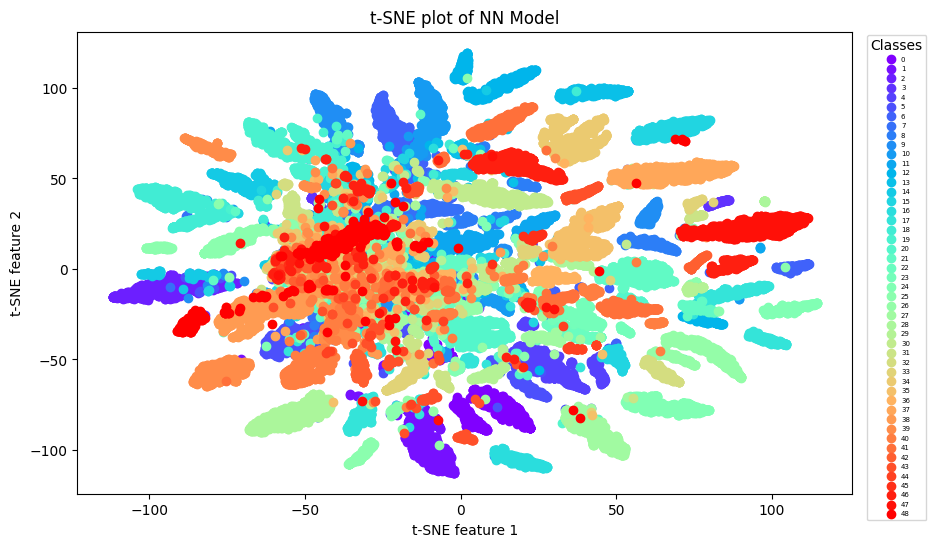

In [151]:
plt.figure(figsize=(10, 6))
unique_labels = np.unique(label_output)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    plt.scatter(model_tsne_outputs[label_output == label, 0], 
                model_tsne_outputs[label_output == label, 1], 
                color=colors[i], 
                label=label)
    
plt.title('t-SNE plot of NN Model')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(handlelength=2, fontsize=5, handletextpad=0.5, borderpad=0.5, bbox_to_anchor=(1.10, 1),title="Classes")
plt.show()

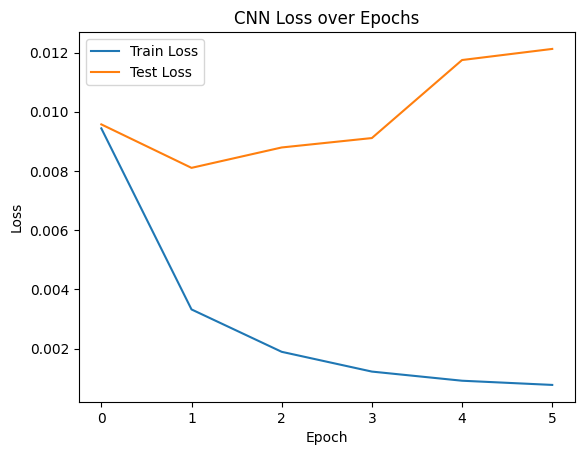

In [152]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [154]:
from prettytable import PrettyTable

model_accuracies = {
    'SVC': {'train_accuracy': svc_score_train, 'test_accuracy': svc_score},
    'SVC GridSearch': {'train_accuracy': best_svc_train, 'test_accuracy': best_svc_test},
    'KNN': {'train_accuracy': knn_score_train, 'test_accuracy': knn_score},
    'KNN GridSearch': {'train_accuracy': best_knn_f1_train, 'test_accuracy': best_knn_f1},
    'CNN': {'train_accuracy': cnn_train_f1, 'test_accuracy': cnn_test_f1}
}

table = PrettyTable()
table.field_names = ["Model", "Train F1 Score", "Test F1 Score"]

for model, accuracies in model_accuracies.items():
    train_accuracy_rounded = round(accuracies['train_accuracy'], 3)
    test_accuracy_rounded = round(accuracies['test_accuracy'], 3)
    table.add_row([model, train_accuracy_rounded, test_accuracy_rounded])

print(table)

+----------------+----------------+---------------+
|     Model      | Train F1 Score | Test F1 Score |
+----------------+----------------+---------------+
|      SVC       |     0.942      |     0.424     |
| SVC GridSearch |     0.876      |     0.482     |
|      KNN       |     0.667      |     0.503     |
| KNN GridSearch |      1.0       |     0.515     |
|      CNN       |     0.995      |     0.938     |
+----------------+----------------+---------------+
